# Imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

In [114]:
df_cat = pd.read_csv('./data/data_categorielles (1).csv')
df_num = pd.read_csv('./data/var_num.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

# Preprocessing

In [127]:
data = pd.concat([df_num,df_cat],axis = 1)

In [128]:
data['date'] = df_app['date_mensuelle'].copy()

In [129]:
data['date'] = pd.to_datetime(data['date'])

In [130]:
data.drop(columns = ['Unnamed: 0','NAME_HOUSING_TYPE','AMT_ANNUITY_disc_int'],inplace = True)

In [131]:
data.isna().sum()/len(data)*100 

DAYS_BIRTH_disc_int                    0.0
EXT_SOURCE_2_disc_int                  0.0
AMT_GOODS_PRICE_disc_int               0.0
REGION_POPULATION_RELATIVE_disc_int    0.0
DAYS_EMPLOYED_disc_int                 0.0
DAYS_REGISTRATION_disc_int             0.0
EXT_SOURCE_3_disc_int                  0.0
AMT_CREDIT_disc_int                    0.0
REGION_RATING_CLIENT_W_CITY            0.0
REGION_RATING_CLIENT                   0.0
FLAG_PHONE                             0.0
LIVE_CITY_NOT_WORK_CITY                0.0
REG_CITY_NOT_LIVE_CITY                 0.0
REG_CITY_NOT_WORK_CITY                 0.0
FLAG_EMP_PHONE                         0.0
TARGET                                 0.0
SK_ID_CURR                             0.0
NAME_CONTRACT_TYPE                     0.0
CODE_GENDER                            0.0
FLAG_OWN_CAR                           0.0
FLAG_OWN_REALTY                        0.0
NAME_INCOME_TYPE_discret               0.0
NAME_EDUCATION_TYPE_discret            0.0
NAME_FAMILY

# Encoding

In [132]:
for col in data.select_dtypes(include = 'object').columns:
    print(f"{col} : {data[col].nunique()}")

DAYS_BIRTH_disc_int : 3
EXT_SOURCE_2_disc_int : 3
AMT_GOODS_PRICE_disc_int : 2
REGION_POPULATION_RELATIVE_disc_int : 2
DAYS_EMPLOYED_disc_int : 2
DAYS_REGISTRATION_disc_int : 2
EXT_SOURCE_3_disc_int : 2
AMT_CREDIT_disc_int : 2
NAME_CONTRACT_TYPE : 2
CODE_GENDER : 3
FLAG_OWN_CAR : 2
FLAG_OWN_REALTY : 2
NAME_INCOME_TYPE_discret : 2
NAME_EDUCATION_TYPE_discret : 2
NAME_FAMILY_STATUS_discret : 2


# Encoding

In [133]:
for col in data.select_dtypes(include = 'object').columns :
    print(f'{col} : {data[col].unique()}')

DAYS_BIRTH_disc_int : ['[-13537--7489]' '[-19303--13538]' '[-25229--19304]']
EXT_SOURCE_2_disc_int : ['[0.48-0.85]' '[0.0-0.15]' '[0.15-0.48]']
AMT_GOODS_PRICE_disc_int : ['[679500.0-4050000.0]' '[40500.0-676278.0]']
REGION_POPULATION_RELATIVE_disc_int : ['[0.0-0.03]' '[0.03-0.07]']
DAYS_EMPLOYED_disc_int : ['[-2443-365243]' '[-17912--2444]']
DAYS_REGISTRATION_disc_int : ['[-6170.0-0.0]' '[-24672.0--6171.0]']
EXT_SOURCE_3_disc_int : ['[0.32-0.9]' '[0.0-0.32]']
AMT_CREDIT_disc_int : ['[675000.0-4050000.0]' '[45000.0-674842.5]']
NAME_CONTRACT_TYPE : ['Cash loans' 'Revolving loans']
CODE_GENDER : ['M' 'F' 'XNA']
FLAG_OWN_CAR : ['Y' 'N']
FLAG_OWN_REALTY : ['Y' 'N']
NAME_INCOME_TYPE_discret : ['high_income' 'low_income']
NAME_EDUCATION_TYPE_discret : ['lower' 'higher']
NAME_FAMILY_STATUS_discret : ['couple' 'alone']


In [134]:
for col in data.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(data[col], prefix=col, drop_first=True)
    data = data.drop(col, axis=1)
    data = data.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in data.select_dtypes(include=bool).columns:
    data[col] = data[col].astype(int)

# Train test split

In [158]:
X = data.drop(columns = ['TARGET', 'SK_ID_CURR'], axis=1).copy()
X = X[X['date']<'2020-01-01']
y = data[data['date']<'2020-01-01']['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [159]:
X_train.drop(columns = ['date'],inplace = True)
X_test.drop(columns =['date'],inplace = True)

# Test avec fonction de perte customisée

In [172]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score


class_weight = {0: 1, 1: 5}  # Pénaliser plus fortement la classe 1 (positifs)


model = LogisticRegression(class_weight=class_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:")
print(conf_matrix)

aucc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("AUCC:", aucc)

Matrice de confusion:
[[22978  1752]
 [ 1479   566]]
AUCC: 0.7214966429615891


# LOGIT

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24725834556445495
            Iterations: 137
            Function evaluations: 137
            Gradient evaluations: 137


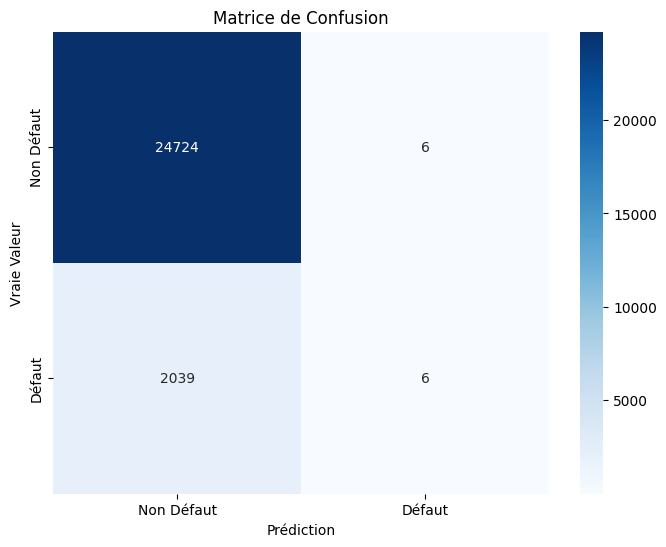

In [160]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

X_train_scaled = sm.add_constant(X_train)

X_test_scaled = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_scaled)
result = model.fit_regularized(method='l1')


# Predictions on training set
y_pred = result.predict(X_test_scaled)
y_pred = y_pred.apply(lambda x: 1 if x>0.5 else 0)

conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Non Défaut', 'Défaut'], 
            yticklabels=['Non Défaut', 'Défaut'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie Valeur')
plt.title('Matrice de Confusion')
plt.show()

# Résultats

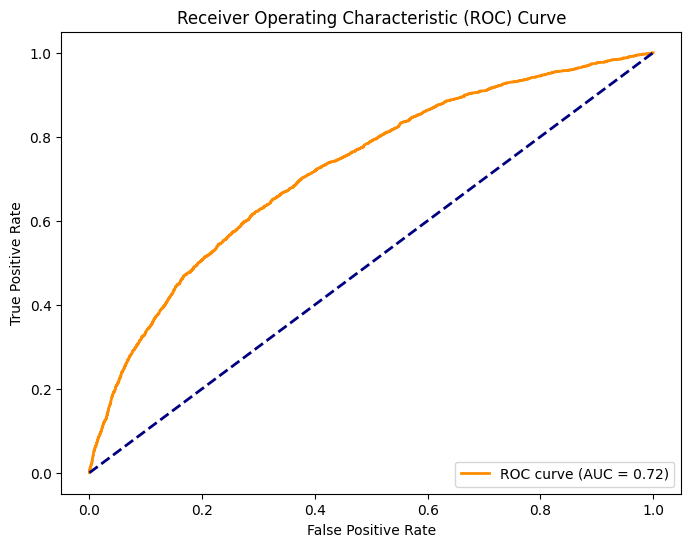

Coefficient de Gini: 0.44246027265617816


In [165]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_test_scaled = sm.add_constant(X_test)


y_prob = result.predict(X_test_scaled)


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

y_prob = result.predict(X_test_scaled)

# Calculer le taux de faux positifs (FPR), le taux de vrais positifs (TPR) et les seuils
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Calculer le coefficient de Gini
gini_coefficient = 2 * roc_auc - 1
print("Coefficient de Gini:", gini_coefficient)

# Coefficients

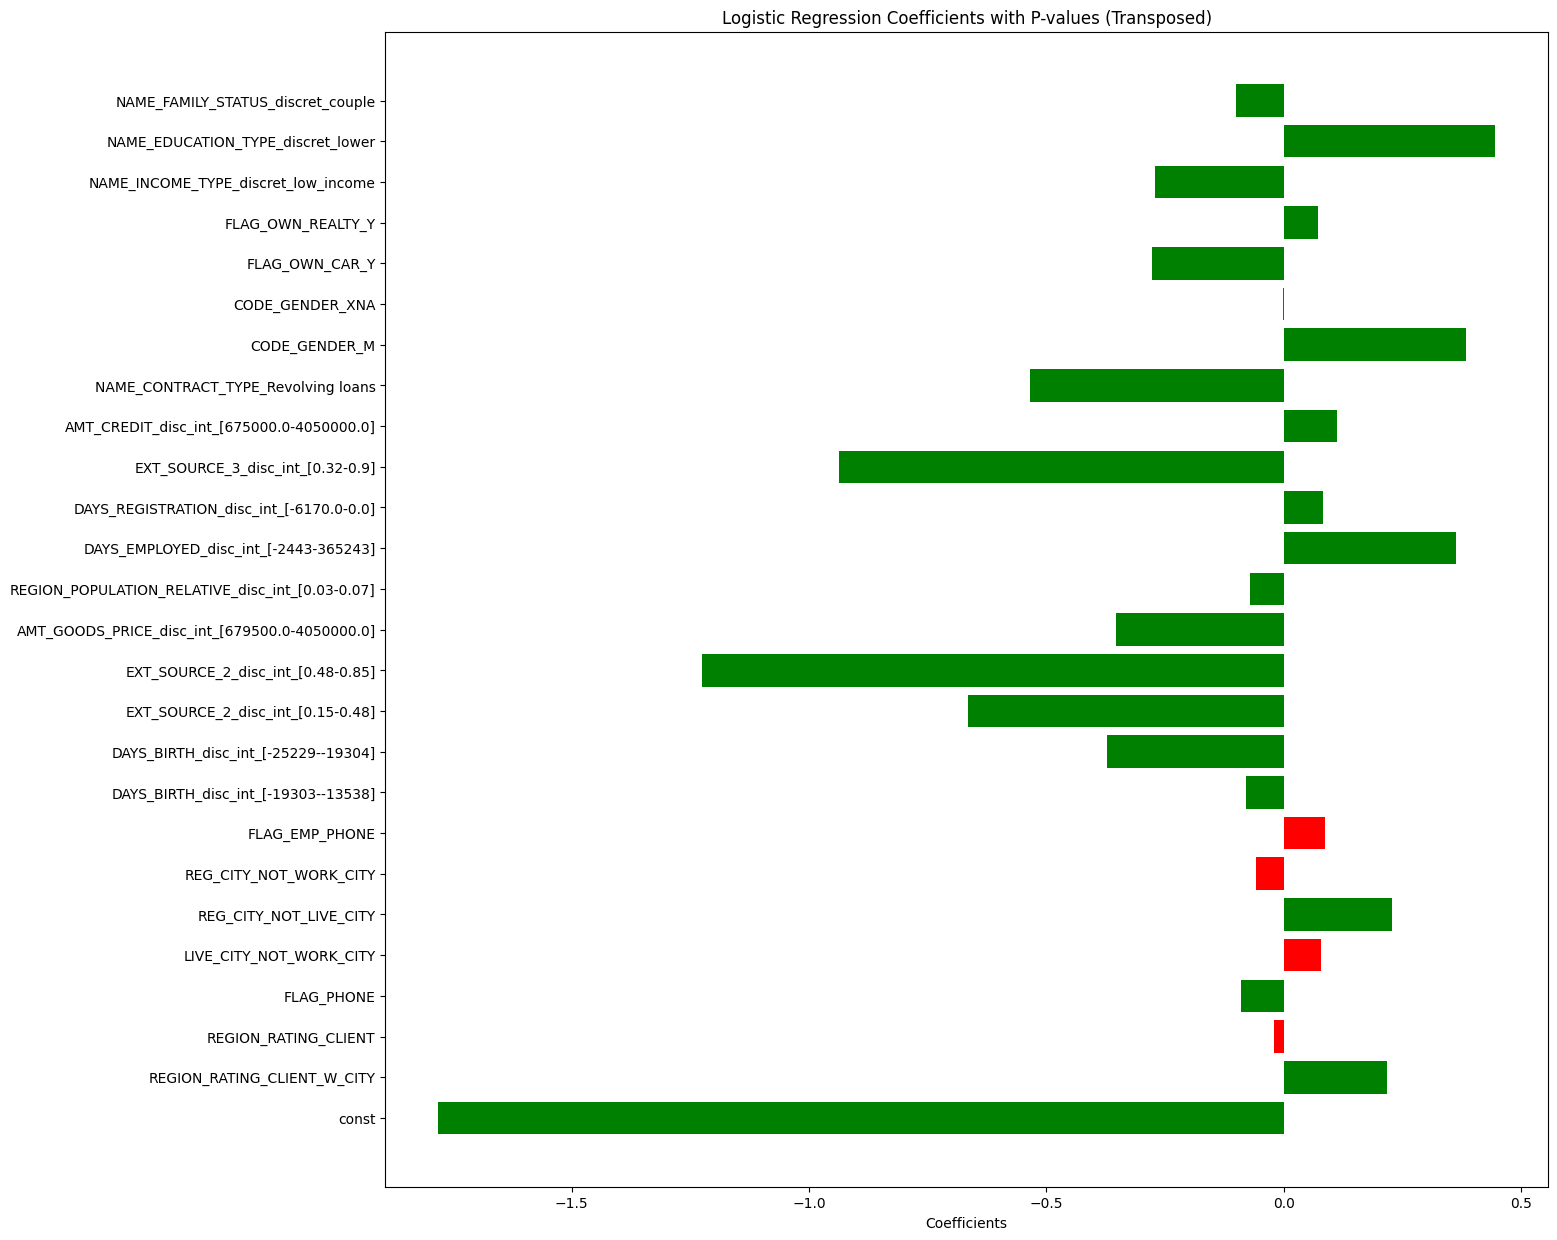

In [155]:
coefficients = result.params
pvalues = result.pvalues

var_signif = [variable for variable, p_value in zip(X_test_scaled.columns, pvalues) if p_value < 0.05]

# Plot des coefficients avec des couleurs différentes en fonction des p-values (transposé)
colors = ['red' if p > 0.05 else 'green' for p in pvalues]

plt.figure(figsize=(15, 15))
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), X_test_scaled.columns)
plt.xlabel('Coefficients')
plt.title('Logistic Regression Coefficients with P-values (Transposed)')
plt.show()

In [67]:
var_signif.pop(0)

'const'

In [68]:
var_signif

['REGION_RATING_CLIENT_W_CITY',
 'FLAG_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'FLAG_EMP_PHONE',
 'DAYS_BIRTH_disc_int_[-19303--13538]',
 'DAYS_BIRTH_disc_int_[-25229--19304]',
 'EXT_SOURCE_2_disc_int_[0.15-0.48]',
 'EXT_SOURCE_2_disc_int_[0.48-0.85]',
 'AMT_GOODS_PRICE_disc_int_[679500.0-4050000.0]',
 'REGION_POPULATION_RELATIVE_disc_int_[0.03-0.07]',
 'DAYS_EMPLOYED_disc_int_[-2443-365243]',
 'DAYS_REGISTRATION_disc_int_[-6170.0-0.0]',
 'EXT_SOURCE_3_disc_int_[0.32-0.9]',
 'AMT_CREDIT_disc_int_[675000.0-4050000.0]',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_discret_low_income',
 'NAME_EDUCATION_TYPE_discret_lower',
 'NAME_FAMILY_STATUS_discret_couple']

# Deuxième modèle avec uniquement les var correlées à + de 5% avec TARGET

In [69]:
X_bis = data[var_signif]

X_train, X_test, y_train, y_test = train_test_split(X_bis, y, test_size=0.2, random_state=889)


X_train_scaled = sm.add_constant(X_train)

model = sm.Logit(y_train, X_train)
result = model.fit_regularized(method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2482452197993522
            Iterations: 105
            Function evaluations: 105
            Gradient evaluations: 105


In [70]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               244885
Model:                          Logit   Df Residuals:                   244864
Method:                           MLE   Df Model:                           20
Date:                Sat, 17 Feb 2024   Pseudo R-squ.:                 0.08039
Time:                        19:03:45   Log-Likelihood:                -60792.
converged:                       True   LL-Null:                       -66106.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
REGION_RATING_CLIENT_W_CITY                        -0.0154      0.016     -0.966      0.334      -0.047       0.016
FLAG_PHONE          

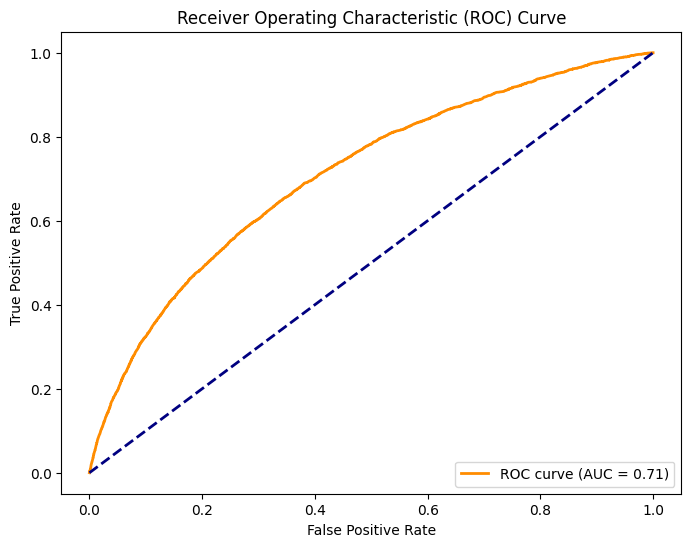

In [71]:
#X_test_cst = sm.add_constant(X_test)


y_prob = result.predict(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

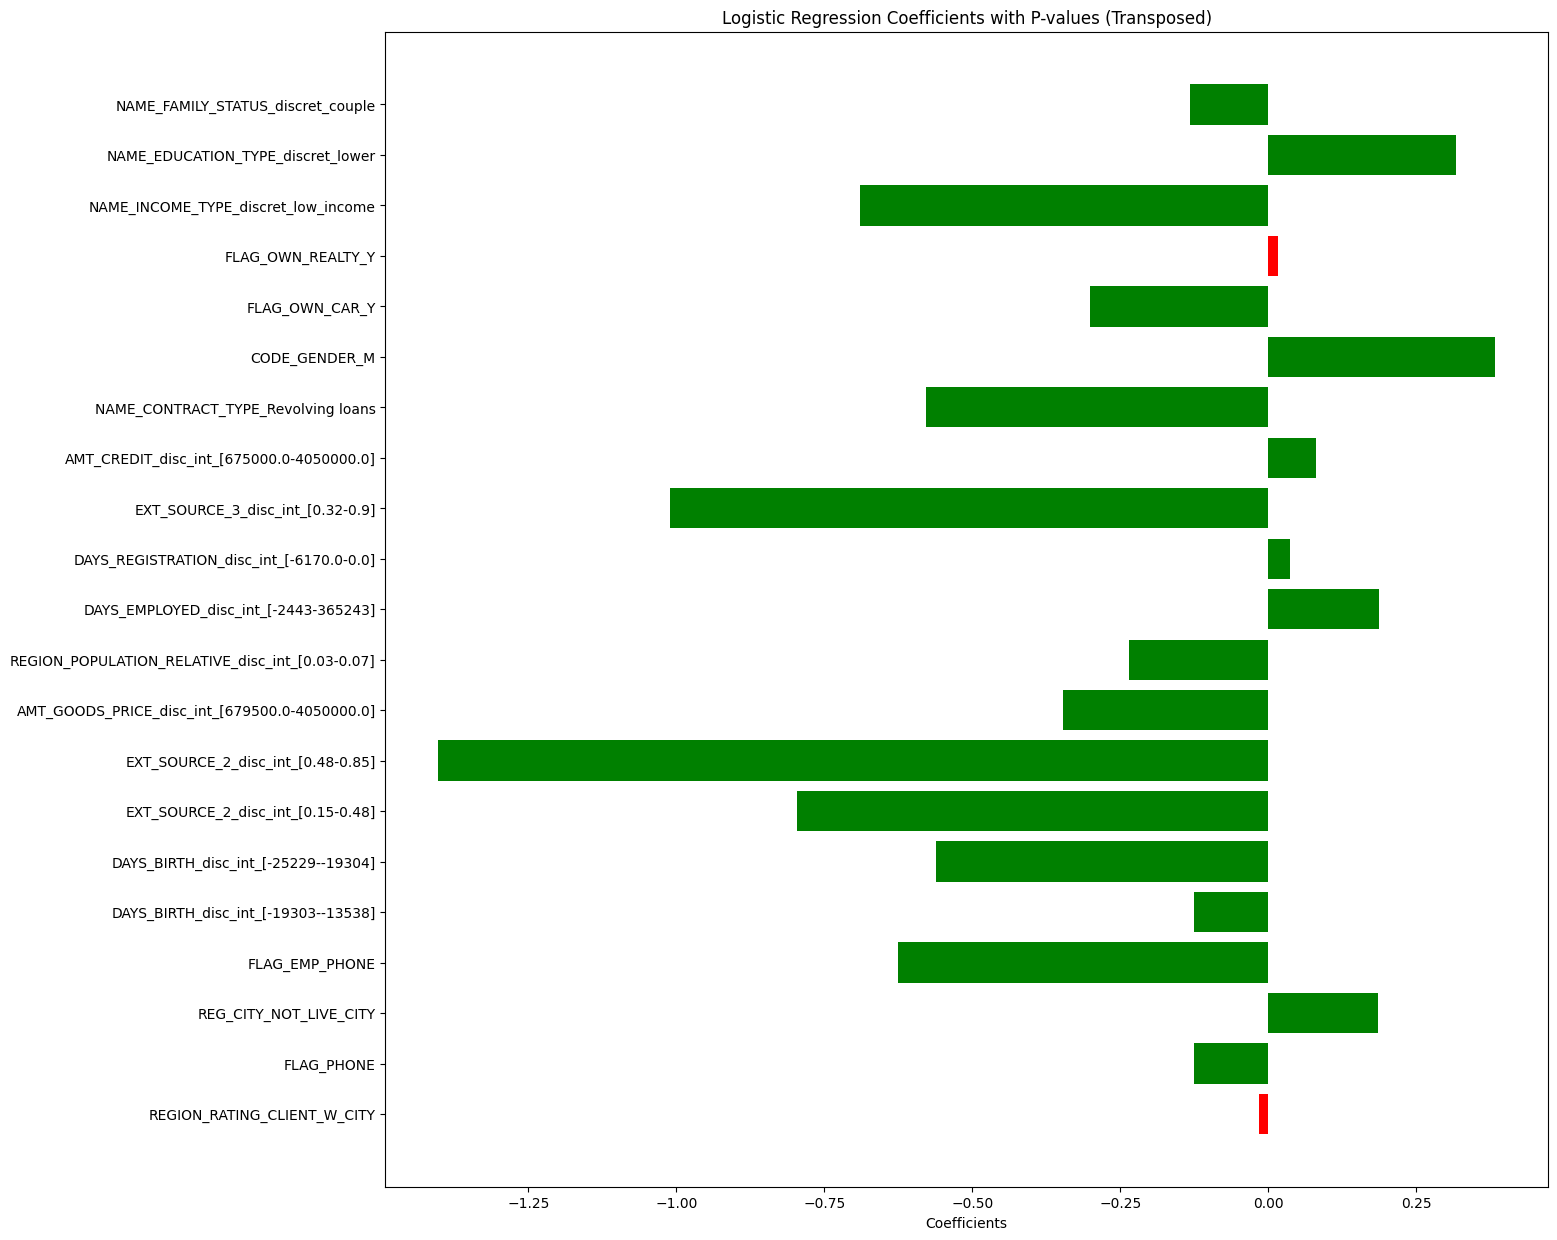

In [73]:
coefficients = result.params
pvalues = result.pvalues

var_signif = [variable for variable, p_value in zip(X.columns, pvalues) if p_value < 0.05]

# Plot des coefficients avec des couleurs différentes en fonction des p-values (transposé)
colors = ['red' if p > 0.05 else 'green' for p in pvalues]

plt.figure(figsize=(15, 15))
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), X_bis.columns)
plt.xlabel('Coefficients')
plt.title('Logistic Regression Coefficients with P-values (Transposed)')
plt.show()